In [1]:
!pip install pyspark

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyspark
import sklearn

from IPython.display import display

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from sklearn.cluster import DBSCAN, BisectingKMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer


import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder \
    .appName("Cluster Analysis") \
    .getOrCreate()

In [6]:
spark_df = spark.read.option("header", "True") \
                .option("inferSchema", "True") \
                .option("quote", '"') \
                .option("escape", '"') \
                .option("sep", ",") \
                .option("ignoreLeadingWhiteSpace", "True") \
                .option("ignoreTrailingWhiteSpace", "True") \
                .option("multiLine", "True") \
                .option("mode", "PERMISSIVE") \
                .csv("/content/gun_violence_cleaned_data_2013_2018.csv")
                #.csv("../data/gun_violence_cleaned_data_2013_2018.csv") \


In [34]:
spark_df.show(10)

+-----------+----------+--------------+-------------------+--------------------+--------+---------+----------------------+------------------------+--------+---------+---------------+--------------------+----+-----+-----------+--------------------------+----------------------+-----------------------+----------------+------------------+-------------------+---------------------+----------------+-----------------+----------------+--------------------+-------------------+---------------------+-----------------+-----------------+----------------+---------------------+-----------------+---------------------------------------+-------------------------------------+-------------------------------------+------------------------------+----------------------------+--------------------------------+-------------------------------+------------------------------+--------------------------------+-------------------------------------+----------------------------+
|incident_id|      date|         state|  

# Location Based Clustering

## K-Means analysis considering latitude, longitude, number of killings, and number of injuries

In [9]:
# Select the desired features from the original dataframe
kmeans_df = spark_df.select(['n_killed', 'n_injured', 'latitude', 'longitude'])

# Filter latitude and longitude values
kmeans_df = kmeans_df.filter((kmeans_df['longitude'] < 0) & (kmeans_df['latitude'] > 0))

# Create a vector of the features that require scaling (n_killed and n_injured)
assembler = VectorAssembler(inputCols = ['n_killed', 'n_injured'], outputCol = 'features_to_scale')
kmeans_df = assembler.transform(kmeans_df)

# Scale the features
scaler = pyspark.ml.feature.StandardScaler(inputCol = 'features_to_scale', outputCol= 'scaled_features', withMean = True)
kmeans_df = scaler.fit(kmeans_df).transform(kmeans_df)

# Create a vector containing the rest of the features (latitude and longitude)
assembler = VectorAssembler(inputCols = ['scaled_features', 'latitude', 'longitude'], outputCol = 'features')
kmeans_df = assembler.transform(kmeans_df)

# Drop the intermediate scaling columns
kmeans_df = kmeans_df.drop('features_to_scale', 'scaled_features')

kmeans_df.show(5)


+--------+---------+--------+---------+--------------------+
|n_killed|n_injured|latitude|longitude|            features|
+--------+---------+--------+---------+--------------------+
|       0|        1| 34.1259| -118.186|[-0.4752424548804...|
|       0|        0| 36.0633| -79.7785|[-0.4752424548804...|
|       0|        1| 32.7866| -83.7199|[-0.4752424548804...|
|       0|        1| 34.2291| -91.9779|[-0.4752424548804...|
|       0|        0| 37.5724| -77.4825|[-0.4752424548804...|
+--------+---------+--------+---------+--------------------+
only showing top 5 rows



In [36]:
def optimal_clusters(df, max_k = 25):
  """
  Creates an elbow plot that displays the inertia value for each number of clusters.
  Can be used to determine the optimal number of clusters based on the
  rate of change of the inertia values.

  Parameters:
  df (DataFrame): The DataFrame containing the features to perform the K-Means algorithm with.
  max_k (int): The maximum number of clusters to test.

  Returns:
  None: Displays the elbow plot.
  """
  number_of_clusters = []
  wsse = []

  for num in range(3, max_k):
    kmeans = KMeans(featuresCol = 'features', k = num, seed = 42)
    model = kmeans.fit(df)

    cost = model.summary.trainingCost

    number_of_clusters.append(num)
    wsse.append(cost)

  fig = plt.subplots(figsize = (10, 5))
  plt.plot(number_of_clusters, wsse, 'o-')
  plt.title("Elbow Method")
  plt.xlabel('Number of clusters')
  plt.ylabel('Within-Cluster Sum of Squared Errors')
  plt.grid(True)
  plt.show()

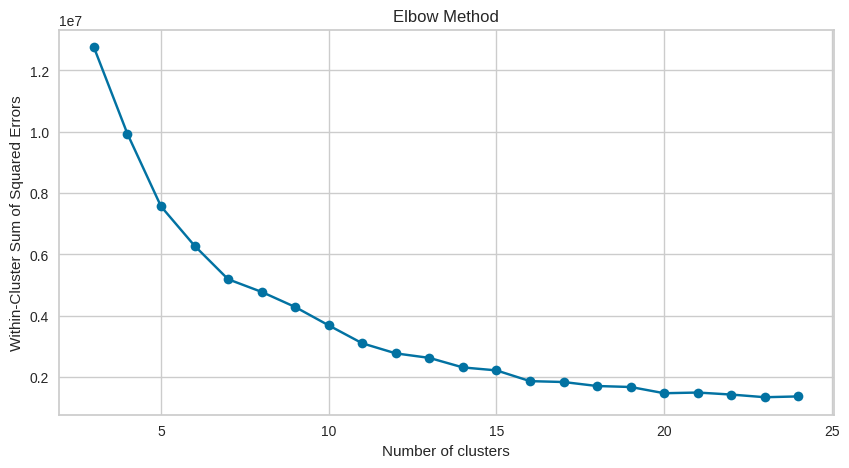

In [37]:
# Find the optimal number of clusters
optimal_clusters(kmeans_df)

In [10]:
# Perform KMeans Clustering
kmeans = KMeans(featuresCol = 'features', k = 11, seed = 42)
model = kmeans.fit(kmeans_df)

# Make predictions
predictions = model.transform(kmeans_df)

# Evaluate the clustering with the Silhouette score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(predictions)
print('Silhouette Score: {:.4f}'.format(silhouette))

# Evaluate the clustering with the Davies-Bouldin Index
dbi_X = predictions.select(['n_killed', 'n_injured', 'latitude', 'longitude']).toPandas().values.tolist()
dbi_labels = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
dbi = davies_bouldin_score(dbi_X, dbi_labels)
print('Davies-Bouldin Index: {:.4f}'.format(dbi))

Silhouette Score: 0.6076
Davies-Bouldin Index: 0.6866


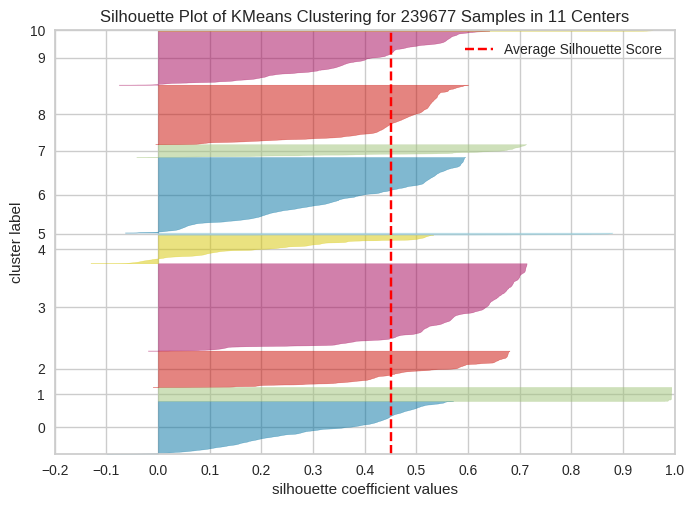

<Figure size 800x550 with 0 Axes>

In [44]:
kmeans_df = spark_df.select(['n_killed', 'n_injured', 'latitude', 'longitude']).toPandas()
model = sklearn.cluster.KMeans(n_clusters=11, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(kmeans_df)
visualizer.show()

We can see the clustering achieves a decent silhouette score indicating that the algorithm did a relatively good job of clustering similar points, as well as a relatively good Davies-Bouldin index of less than 1 considering the large size of the data set which is a moderately good indication of separation and compactness of clusters.

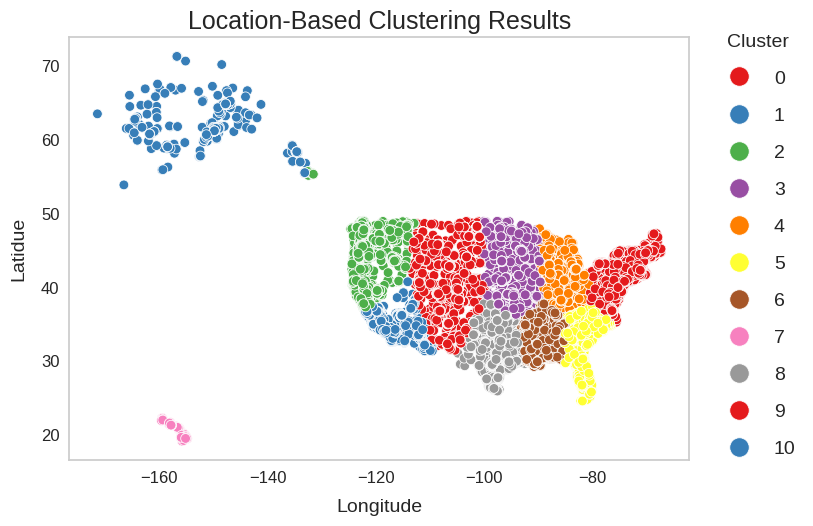

In [54]:
# Convert the data to Pandas for plotting
predictions_pd = predictions.select('prediction').toPandas()
predicted_labels = predictions_pd['prediction'].values
longArray = np.array([row['longitude'] for row in predictions.select('longitude').collect()])
latArray = np.array([row['latitude'] for row in predictions.select('latitude').collect()])
labels = np.unique(predicted_labels)

sns.scatterplot(x = longArray, y = latArray, hue=predicted_labels, palette ='Set1')
plt.title('Location-Based Clustering Results', fontsize = 18)
plt.xlabel('Longitude', labelpad = 10, fontsize = 14)
plt.ylabel('Latidue', labelpad = 10, fontsize = 14)
plt.tick_params(axis = 'both', labelsize = 12)
plt.legend(title = 'Cluster',
           markerscale = 2,
           labelspacing = 1,
           title_fontsize = 14,
           fontsize = 14,
           bbox_to_anchor = (1.2, 1.05))
plt.grid(False)
plt.show()

In [ ]:
predictions.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|51501|
|         1| 1271|
|         2|12956|
|         3|17844|
|         4|44776|
|         5|38735|
|         6|25824|
|         7|  277|
|         8|17603|
|         9| 7564|
|        10|13398|
+----------+-----+



In [13]:
# Analyze the cluster centroids
centroids_summary = predictions.drop('features').groupBy('prediction').avg().orderBy('prediction').drop('avg(prediction)')

# Create a new column summing average killed and injured
centroids_summary = centroids_summary.withColumn("Avg_Killed_and_Injured", col('avg(n_killed)') + col('avg(n_injured)'))

column_names = ['Prediction', 'Avg_Number_Killed', 'Avg_Number_Injured', 'Avg_Latitude', 'Avg_Longitude', 'Avg_Killed_and_Injured']
centroids_summary = centroids_summary.toDF(*column_names)

centroids_summary.orderBy(desc('Avg_Killed_and_Injured')).show()

+----------+-------------------+-------------------+------------------+-------------------+----------------------+
|Prediction|  Avg_Number_Killed| Avg_Number_Injured|      Avg_Latitude|      Avg_Longitude|Avg_Killed_and_Injured|
+----------+-------------------+-------------------+------------------+-------------------+----------------------+
|        10| 0.3972234661889834| 0.4732795939692491| 34.63638172861612|-117.05042991491298|    0.8705030601582325|
|         4|0.22150259067357514| 0.6189923173128462|41.146710096926505| -85.73868372789072|    0.8404949079864213|
|         6|0.27482187112763323|  0.537639405204461| 33.07800068153651| -88.92021293370573|    0.8124612763320942|
|         8|0.33534056694881553| 0.4537862864284497| 31.87920743623235| -96.75064584445954|    0.7891268533772653|
|         5|0.25589260358848587|0.47858525880986186| 32.06478056796168| -81.45868457983683|    0.7344778623983477|
|         0| 0.1883846915593872| 0.4766121046193278|40.487910914350735| -75.1198

In [ ]:
sns.scatterplot(x = longArray, y = latArray, hue=predicted_labels, palette ='Set1')
plt.title('Location-Based Clustering Results', fontsize = 18)
plt.xlabel('Longitude', labelpad = 10, fontsize = 14)
plt.ylabel('Latidue', labelpad = 10, fontsize = 14)
plt.tick_params(axis = 'both', labelsize = 12)
plt.legend(title = 'Cluster',
           markerscale = 2,
           labelspacing = 1,
           title_fontsize = 14,
           fontsize = 14,
           bbox_to_anchor = (1.2, 1.05))
plt.grid(False)
plt.show()

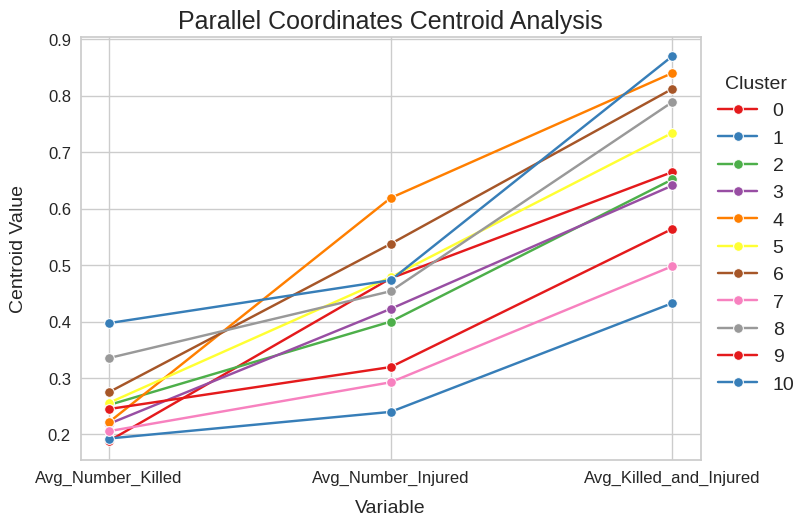

In [59]:
centroids_pd = centroids_summary.drop('Prediction', 'Avg_Latitude', 'Avg_Longitude').toPandas()

melt = centroids_pd.reset_index().melt(id_vars = 'index', var_name = "Variable", value_name = "Average")
melt

sns.lineplot(melt, x = 'Variable', y = 'Average', hue = 'index', palette = 'Set1', marker = 'o')
plt.title('Parallel Coordinates Centroid Analysis', fontsize = 18)
plt.xlabel('Variable', labelpad = 10, fontsize = 14)
plt.ylabel('Centroid Value', labelpad = 15, fontsize = 14)
plt.tick_params(axis = 'both', labelsize = 12)
plt.legend(title = 'Cluster',
           bbox_to_anchor = (1, 0.95),
           title_fontsize = 14,
           fontsize = 14)
#plt.gca().yaxis.tick_right()
#plt.gca().yaxis.set_label_position('right')
plt.show()

By looking at the plot along with the cluster centroids we can see that the areas with the highest averages in killings and injuries combined are mainly located in the southwest, along with midwestern states from Wisconsin and Michigan down to Mississippi and Alabama.

The area responsible for the highest average number of people killed is located in the southwest, mainly consisting of southern California, Nevada, and Arizona. We can also see that the area consisting of Texas, Oklahoma, and southern Kansas has a relatively high average in the number of people killed.

Analyzing the average number of people injured, we can see that the highest averages come from clusters located in the eastern half of the country. It seems as though the average number of injuries almost splits the country in half, with all the eastern states having a higher average number of people injured and the western states having a lower average number of people injured.

## DBSCAN considering latitude, longitude, number of killings, and number of injuries




In [ ]:
# Select columns from original dataframe
dbscan_df = spark_df.select(['n_killed', 'n_injured', 'latitude', 'longitude']).toPandas()

# Filter latitude and longitude values
dbscan_df = dbscan_df[((dbscan_df['longitude'] < 0) & (dbscan_df['latitude'] > 0))]
print("Original dataframe:")
display(dbscan_df.head())
print()

# Scale the features
scaler = sklearn.preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(dbscan_df[['n_killed', 'n_injured']])

dbscan_df[['n_killed', 'n_injured']] = scaled_features
print("Scaled dataframe:")
display(dbscan_df.head())

Original dataframe:


,n_killed,n_injured,latitude,longitude
0,0,1,34.1259,-118.1860
1,0,0,36.0633,-79.7785
2,0,1,32.7866,-83.7199
3,0,1,34.2291,-91.9779
4,0,0,37.5724,-77.4825



Scaled dataframe:


,n_killed,n_injured,latitude,longitude
0,-0.475243,0.691411,34.1259,-118.1860
1,-0.475243,-0.675608,36.0633,-79.7785
2,-0.475243,0.691411,32.7866,-83.7199
3,-0.475243,0.691411,34.2291,-91.9779
4,-0.475243,-0.675608,37.5724,-77.4825


In [ ]:
# Perform DBSCAN
db = DBSCAN(eps = 0.5, min_samples = 100).fit(dbscan_df)

# Print number of clusters and noisy points
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = list(db.labels_).count(-1)
print("Estimated number of clusters: %d" % n_clusters)
print('Estimated number of noisy points: %d' % n_noise)
print()

# Evaluate the clustering with the Silhouette score
silhouette = silhouette_score(dbscan_df, db.labels_)
print('Silhouette Score: {:.4f}'.format(silhouette))

# Evaluate the clustering with the Davies-Bouldin Index
dbi = davies_bouldin_score(dbscan_df, db.labels_)
print('Davies-Bouldin Index: {:.4f}'.format(dbi))

Estimated number of clusters: 193
Estimated number of noisy points: 34988

Silhouette Score: 0.0068
Davies-Bouldin Index: 1.8770


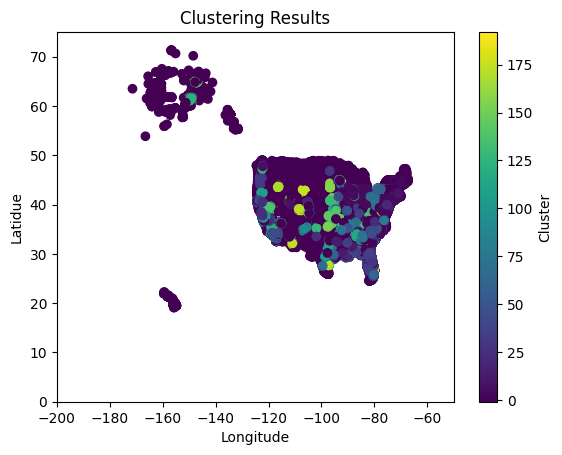

In [ ]:
# Plot clustering results
fig = plt.figure(1)

scatter = plt.scatter(long_pd, lat_pd, c=db.labels_)
plt.ylim(0,75)
plt.xlim(-200,-50)
plt.xlabel('Longitude')
plt.ylabel('Latidue')
plt.title('Clustering Results')
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster')
plt.show()

# Demographic Clustering

## K-Means clustering analyzing participant age, gender, and injury status

In [65]:
# Select the desired features from the original dataframe
features = ['participant_age_group_child_0_11_freq',
            'participant_age_group_teen_12_17_freq',
            'participant_age_group_adult_18plus_freq',
            'participant_gender_female_freq',
            'participant_gender_male_freq',
             'participant_status_arrested_freq',
             'participant_status_injured_freq',
             'participant_status_killed_freq',
             'participant_status_unharmed_freq']

kmeans_df = spark_df.select(features)

# Assemble the features into a single column vector
assembler = VectorAssembler(inputCols = features, outputCol = 'features')
kmeans_df = assembler.transform(kmeans_df)

# Scale the features
scaler = pyspark.ml.feature.StandardScaler(inputCol = 'features', outputCol = 'scaled_features', withMean = True)
kmeans_df = scaler.fit(kmeans_df).transform(kmeans_df).drop('features')
kmeans_df = kmeans_df.withColumnRenamed('scaled_features', 'features')

kmeans_df.show(5)

+-------------------------------------+-------------------------------------+---------------------------------------+------------------------------+----------------------------+--------------------------------+-------------------------------+------------------------------+--------------------------------+--------------------+
|participant_age_group_child_0_11_freq|participant_age_group_teen_12_17_freq|participant_age_group_adult_18plus_freq|participant_gender_female_freq|participant_gender_male_freq|participant_status_arrested_freq|participant_status_injured_freq|participant_status_killed_freq|participant_status_unharmed_freq|            features|
+-------------------------------------+-------------------------------------+---------------------------------------+------------------------------+----------------------------+--------------------------------+-------------------------------+------------------------------+--------------------------------+--------------------+
|               

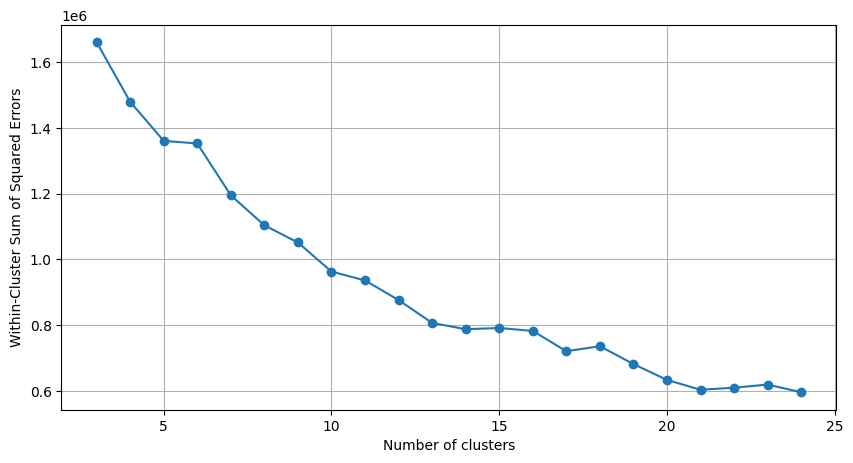

In [ ]:
# Find the optimal number of clusters
optimal_clusters(kmeans_df)

In [66]:
# Perform KMeans Clustering
kmeans = KMeans(featuresCol = 'features', k = 14, seed = 42)
model = kmeans.fit(kmeans_df)

# Make predictions
predictions = model.transform(kmeans_df)

# Evalue the clustering with the silhouette score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(predictions)
print('Silhouette Score: {:.4f}'.format(silhouette))

# Evaluate the clustering with the Davies-Bouldin Index
dbi_X = predictions.select(features).toPandas().values.tolist()
dbi_labels = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
dbi = davies_bouldin_score(dbi_X, dbi_labels)
print('Davies-Bouldin Index: {:.4f}'.format(dbi))

Silhouette Score: 0.3987
Davies-Bouldin Index: 1.6029


In [ ]:
predictions.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|15936|
|         1|   20|
|         2| 9117|
|         3|54487|
|         4|23864|
|         5| 4135|
|         6|21286|
|         7| 1996|
|         8| 3604|
|         9| 3274|
|        10|53391|
|        11|32635|
|        12| 9306|
|        13| 6626|
+----------+-----+



In [67]:
# Display the cluster centroids
centroids_summary = predictions.drop('scaled_features').groupBy('prediction').avg().orderBy('prediction').drop('avg(prediction)')
column_names = ['Prediction', 'Avg_Age_0-11_Freq', 'Avg_Age_12-17_Freq', 'Avg_Age_18plus_Freq', 'Avg_Female_Freq', 'Avg_Male_Freq', 'Avg_Arrested_Freq', 'Avg_Injured_Freq', 'Avg_Killed_Freq', 'Avg_Unharmed_Freq']
centroids_summary = centroids_summary.toDF(*column_names)
centroids_summary.show(14)
#centroids_summary.orderBy(desc('Avg_Age_0-11_Freq')).show()

+----------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|Prediction|   Avg_Age_0-11_Freq|  Avg_Age_12-17_Freq|Avg_Age_18plus_Freq|     Avg_Female_Freq|     Avg_Male_Freq|   Avg_Arrested_Freq|    Avg_Injured_Freq|     Avg_Killed_Freq|   Avg_Unharmed_Freq|
+----------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|         0|                 0.0| 0.06990461847389558| 2.0294929718875503|0.003451305220883534|2.1672314257028114|  0.5196410642570282|  0.1934613453815261|  1.0871611445783131|  0.8371611445783133|
|         1|                0.05|                 0.2|               27.8|                3.85|             21.25|               23.55|                 3.5|                 2.5|                23.2|
|    

## Divisive hierarchical clustering analyzing participant age, gender, and injury status

In [ ]:
features = ['participant_age_group_child_0_11_freq',
            'participant_age_group_teen_12_17_freq',
            'participant_age_group_adult_18plus_freq',
            'participant_gender_female_freq',
            'participant_gender_male_freq',
             'participant_status_arrested_freq',
             'participant_status_injured_freq',
             'participant_status_killed_freq',
             'participant_status_unharmed_freq']

# Select features from original data
divisive_df = spark_df.select(features).toPandas()
print("Original dataframe:")
display(divisive_df.head())
print()

# Scale the features
scaler = sklearn.preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(divisive_df)

divisive_df = pd.DataFrame(scaled_features, columns = features)
print("Scaled dataframe:")
display(divisive_df.head())

Original dataframe:


,participant_age_group_child_0_11_freq,participant_age_group_teen_12_17_freq,participant_age_group_adult_18plus_freq,participant_gender_female_freq,participant_gender_male_freq,participant_status_arrested_freq,participant_status_injured_freq,participant_status_killed_freq,participant_status_unharmed_freq
0,0,0,1,0,1,0,1,0,0
1,0,0,1,1,0,0,0,0,1
2,0,0,2,0,2,0,1,0,1
3,0,0,2,0,2,0,1,0,1
4,0,0,1,0,1,0,0,0,1



Scaled dataframe:


,participant_age_group_child_0_11_freq,participant_age_group_teen_12_17_freq,participant_age_group_adult_18plus_freq,participant_gender_female_freq,participant_gender_male_freq,participant_status_arrested_freq,participant_status_injured_freq,participant_status_killed_freq,participant_status_unharmed_freq
0,-0.112304,-0.256493,-0.242711,-0.392873,-0.271221,-0.50887,0.693250,-0.483573,-0.736737
1,-0.112304,-0.256493,-0.242711,1.788178,-1.207709,-0.50887,-0.676748,-0.483573,0.190863
2,-0.112304,-0.256493,0.628678,-0.392873,0.665267,-0.50887,0.693250,-0.483573,0.190863
3,-0.112304,-0.256493,0.628678,-0.392873,0.665267,-0.50887,0.693250,-0.483573,0.190863
4,-0.112304,-0.256493,-0.242711,-0.392873,-0.271221,-0.50887,-0.676748,-0.483573,0.190863


In [ ]:
# Perform divisive hierarchical clustering
bisect_means = BisectingKMeans(n_clusters = 11, random_state = 42).fit(divisive_df)

# Evaluate the clustering with the Silhouette score
silhouette = silhouette_score(divisive_df, bisect_means.labels_)
print('Silhouette Score: {:.4f}'.format(silhouette))

# Evaluate the clustering with the Davies-Bouldin Index
dbi = davies_bouldin_score(divisive_df, bisect_means.labels_)
print('Davies-Bouldin Index: {:.4f}'.format(dbi))

Silhouette Score: 0.2945
Davies-Bouldin Index: 1.5057


In [ ]:
# Display the cluster centroids
centroids_df = pd.DataFrame(bisect_means.cluster_centers_, columns = features)
centroids_df['label'] = list(range(11))
centroids_df = centroids_df[['label'] + features]
display(centroids_df)

,label,participant_age_group_child_0_11_freq,participant_age_group_teen_12_17_freq,participant_age_group_adult_18plus_freq,participant_gender_female_freq,participant_gender_male_freq,participant_status_arrested_freq,participant_status_injured_freq,participant_status_killed_freq,participant_status_unharmed_freq
0,0,0.028474,-0.256493,-0.277102,-0.154150,-0.306975,-0.432363,0.872102,-0.462177,-0.605739
1,1,-0.015661,2.487147,-0.918961,-0.081933,-0.122056,-0.402332,0.905848,-0.406505,-0.497998
2,2,-0.029488,-0.110054,-0.315157,-0.244419,-0.309275,-0.489990,-0.672967,1.447578,-0.672931
3,3,-0.092573,-0.153822,-0.646064,-0.312624,-0.641503,-0.007553,-0.675868,-0.483573,-0.148101
4,4,-0.011808,0.334292,2.839597,-0.199442,3.270824,4.624201,-0.054446,0.141797,3.379721
5,5,-0.015762,4.718679,-0.034319,-0.289431,1.659361,1.754212,0.060035,0.062323,1.602128
6,6,-0.058709,-0.143928,0.791140,-0.386738,0.961922,0.434189,-0.646572,0.605615,0.887309
7,7,-0.060357,-0.127845,0.949045,-0.386109,1.180288,0.004523,1.065717,-0.156203,0.360291
8,8,8.406452,0.257910,0.977481,2.856258,0.849375,0.157138,0.684500,1.193466,1.382458
9,9,-0.112304,0.511689,2.397490,2.887807,1.495393,1.838674,0.610184,0.181196,2.218054


In [ ]:
label, count = np.unique(bisect_means.labels_, return_counts = True)
print(pd.DataFrame({'Label': label, 'Count': count}))

    Label  Count
0       0  55083
1       1   6341
2       2  23551
3       3  73165
4       4   1760
5       5   3478
6       6  27429
7       7  22520
8       8   1409
9       9   4552
10     10  20389


## Gaussian Mixture Model clustering analyzing participant age, gender, and injury status

In [ ]:
features = ['participant_age_group_child_0_11_freq',
            'participant_age_group_teen_12_17_freq',
            'participant_age_group_adult_18plus_freq',
            'participant_gender_female_freq',
            'participant_gender_male_freq',
             'participant_status_arrested_freq',
             'participant_status_injured_freq',
             'participant_status_killed_freq',
             'participant_status_unharmed_freq']

gmm_df = spark_df.select(features).toPandas()
print("Original dataframe:")
display(gmm_df.head())
print()

# Scale the features
scaler = sklearn.preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(gmm_df[features])

gmm_df[features] = scaled_features
print("Scaled dataframe:")
display(gmm_df.head())

Original dataframe:


,participant_age_group_child_0_11_freq,participant_age_group_teen_12_17_freq,participant_age_group_adult_18plus_freq,participant_gender_female_freq,participant_gender_male_freq,participant_status_arrested_freq,participant_status_injured_freq,participant_status_killed_freq,participant_status_unharmed_freq
0,0,0,1,0,1,0,1,0,0
1,0,0,1,1,0,0,0,0,1
2,0,0,2,0,2,0,1,0,1
3,0,0,2,0,2,0,1,0,1
4,0,0,1,0,1,0,0,0,1



Scaled dataframe:


,participant_age_group_child_0_11_freq,participant_age_group_teen_12_17_freq,participant_age_group_adult_18plus_freq,participant_gender_female_freq,participant_gender_male_freq,participant_status_arrested_freq,participant_status_injured_freq,participant_status_killed_freq,participant_status_unharmed_freq
0,-0.112304,-0.256493,-0.242711,-0.392873,-0.271221,-0.50887,0.693250,-0.483573,-0.736737
1,-0.112304,-0.256493,-0.242711,1.788178,-1.207709,-0.50887,-0.676748,-0.483573,0.190863
2,-0.112304,-0.256493,0.628678,-0.392873,0.665267,-0.50887,0.693250,-0.483573,0.190863
3,-0.112304,-0.256493,0.628678,-0.392873,0.665267,-0.50887,0.693250,-0.483573,0.190863
4,-0.112304,-0.256493,-0.242711,-0.392873,-0.271221,-0.50887,-0.676748,-0.483573,0.190863


In [ ]:
# Perform clustering with Gaussian Mixture Model
gmm_labels = GaussianMixture(n_components = 14, random_state = 42).fit_predict(gmm_df)

# Evaluate the clustering with the silhouette score
silhouette = silhouette_score(gmm_df, gmm_labels)
print('Silhouette Score: {:.4f}'.format(silhouette))

# Evaluate the clustering with the Davies-Bouldin Index
dbi = davies_bouldin_score(gmm_df, gmm_labels)
print('Davies-Bouldin Index: {:.4f}'.format(dbi))

0.22909367962873553
Davies-Bouldin Index: 3.2598


In [ ]:
label, count = np.unique(gmm_labels, return_counts = True)
print(pd.DataFrame({'Label': label, 'Count': count}))

    Label  Count
0       0  15040
1       1   8081
2       2  60976
3       3  40199
4       4   3043
5       5   4070
6       6  15918
7       7   1011
8       8   2849
9       9  14212
10     10  31036
11     11  42192
12     12    719
13     13    331


In [ ]:
# Display the cluster centroids
gmm_df['label'] = gmm_labels
gmm_df = gmm_df[['label'] + features]
agg_df = gmm_df.groupby('label').mean()
agg_df.head(14)

,participant_age_group_child_0_11_freq,participant_age_group_teen_12_17_freq,participant_age_group_adult_18plus_freq,participant_gender_female_freq,participant_gender_male_freq,participant_status_arrested_freq,participant_status_injured_freq,participant_status_killed_freq,participant_status_unharmed_freq
label,,,,,,,,,
0,-0.112304,-0.256493,0.621783,1.788178,-0.065990,0.350435,0.048058,-0.483573,0.817302
1,-0.112304,-0.256493,1.556463,2.025419,0.624011,1.109582,-0.237148,1.204235,0.803027
2,-0.112304,-0.256493,-0.064163,-0.056000,-0.223979,-0.508870,0.331114,0.415677,-0.736737
3,-0.112304,-0.256493,0.057297,-0.392873,0.068323,0.905152,-0.333831,-0.483573,0.259258
4,6.670892,-0.056955,-0.245861,0.944571,0.146706,-0.184746,0.376300,0.397490,0.192997
5,-0.112304,2.697187,-0.561934,-0.154940,0.310000,0.726953,0.356641,-0.483573,0.631872
6,-0.112304,-0.256493,0.662563,-0.392873,0.777578,0.281741,-0.460809,1.432849,0.220758
7,-0.112304,3.375517,0.297705,0.933879,1.110817,0.817817,0.603814,1.582599,0.244079
8,-0.112304,-0.256493,1.166376,1.456695,0.838168,0.891428,1.467451,0.748749,1.040323


### Analyzing injured frequency of cluster centroids

In [ ]:
# Evaluate cluster centroids by injured frequency
print("Cluster centroids by injured frequency:")
display(agg_df.sort_values(by = 'participant_status_injured_freq', ascending = False))

Cluster centroids by injured frequency:


,participant_age_group_child_0_11_freq,participant_age_group_teen_12_17_freq,participant_age_group_adult_18plus_freq,participant_gender_female_freq,participant_gender_male_freq,participant_status_arrested_freq,participant_status_injured_freq,participant_status_killed_freq,participant_status_unharmed_freq
label,,,,,,,,,
12,8.615739,1.225551,1.353421,2.358467,1.609571,0.456328,1.819355,0.961073,1.757076
8,-0.112304,-0.256493,1.166376,1.456695,0.838168,0.891428,1.467451,0.748749,1.040323
7,-0.112304,3.375517,0.297705,0.933879,1.110817,0.817817,0.603814,1.582599,0.244079
4,6.670892,-0.056955,-0.245861,0.944571,0.146706,-0.184746,0.376300,0.397490,0.192997
5,-0.112304,2.697187,-0.561934,-0.154940,0.310000,0.726953,0.356641,-0.483573,0.631872
2,-0.112304,-0.256493,-0.064163,-0.056000,-0.223979,-0.508870,0.331114,0.415677,-0.736737
9,-0.112304,2.750062,-0.462581,0.081182,0.462116,0.341297,0.218783,0.044211,0.257046
11,-0.112304,-0.256493,0.177164,-0.392873,0.380472,-0.508870,0.113586,-0.483573,0.477902
0,-0.112304,-0.256493,0.621783,1.788178,-0.065990,0.350435,0.048058,-0.483573,0.817302


By analyzing the cluster centroids focusing on participant injured frequency, we can see that the cluster with the highest participant injured frequency is dominated by participants from ages 0 to 11 as well as a relatively high frequency of females. Though there does not seem to be a strong pattern of higher injury frequencies directly corresponding to young children being involved, it is evident that the cluster with the highest injury frequency is dominated by young children with a relatively high frequency of female children.

### Analyzing killed frequency of cluster centroids

In [ ]:
# Evaluate cluster centroids by killed frequency
print("Cluster centroids by killed frequency:")
display(agg_df.sort_values(by = 'participant_status_killed_freq', ascending = False))

Cluster centroids by killed frequency:


,participant_age_group_child_0_11_freq,participant_age_group_teen_12_17_freq,participant_age_group_adult_18plus_freq,participant_gender_female_freq,participant_gender_male_freq,participant_status_arrested_freq,participant_status_injured_freq,participant_status_killed_freq,participant_status_unharmed_freq
label,,,,,,,,,
7,-0.112304,3.375517,0.297705,0.933879,1.110817,0.817817,0.603814,1.582599,0.244079
6,-0.112304,-0.256493,0.662563,-0.392873,0.777578,0.281741,-0.460809,1.432849,0.220758
1,-0.112304,-0.256493,1.556463,2.025419,0.624011,1.109582,-0.237148,1.204235,0.803027
12,8.615739,1.225551,1.353421,2.358467,1.609571,0.456328,1.819355,0.961073,1.757076
8,-0.112304,-0.256493,1.166376,1.456695,0.838168,0.891428,1.467451,0.748749,1.040323
2,-0.112304,-0.256493,-0.064163,-0.056000,-0.223979,-0.508870,0.331114,0.415677,-0.736737
4,6.670892,-0.056955,-0.245861,0.944571,0.146706,-0.184746,0.376300,0.397490,0.192997
9,-0.112304,2.750062,-0.462581,0.081182,0.462116,0.341297,0.218783,0.044211,0.257046
13,-0.112304,3.912649,3.769363,2.361445,4.068879,6.775450,-0.540162,-0.170924,6.087152


Analyzing participant killed frequency we can see that the cluster with the highest killed frequency mainly consists of participants from ages 12 to 17 with a relatively high frequency of males. Again, there does not seem to be a consistent pattern of high killed frequences always indicating a high frequency of teenagers from age 12 to 17, but the cluster with the highest killed frequency is dominated by this age group.

### Analyzing arrested frequency of cluster centroids

In [ ]:
# Evaluate cluster centroids by arrested frequency
print("Cluster centroids by arrested frequency:")
display(agg_df.sort_values(by = 'participant_status_arrested_freq', ascending = False))

Cluster centroids by arrested frequency:


,participant_age_group_child_0_11_freq,participant_age_group_teen_12_17_freq,participant_age_group_adult_18plus_freq,participant_gender_female_freq,participant_gender_male_freq,participant_status_arrested_freq,participant_status_injured_freq,participant_status_killed_freq,participant_status_unharmed_freq
label,,,,,,,,,
13,-0.112304,3.912649,3.769363,2.361445,4.068879,6.775450,-0.540162,-0.170924,6.087152
1,-0.112304,-0.256493,1.556463,2.025419,0.624011,1.109582,-0.237148,1.204235,0.803027
3,-0.112304,-0.256493,0.057297,-0.392873,0.068323,0.905152,-0.333831,-0.483573,0.259258
8,-0.112304,-0.256493,1.166376,1.456695,0.838168,0.891428,1.467451,0.748749,1.040323
7,-0.112304,3.375517,0.297705,0.933879,1.110817,0.817817,0.603814,1.582599,0.244079
5,-0.112304,2.697187,-0.561934,-0.154940,0.310000,0.726953,0.356641,-0.483573,0.631872
12,8.615739,1.225551,1.353421,2.358467,1.609571,0.456328,1.819355,0.961073,1.757076
0,-0.112304,-0.256493,0.621783,1.788178,-0.065990,0.350435,0.048058,-0.483573,0.817302
9,-0.112304,2.750062,-0.462581,0.081182,0.462116,0.341297,0.218783,0.044211,0.257046


Analyzing participant arrested frequency, as one would intuitively expect we can see that there appears to be a pattern of a high arrested frequency corresponding with a high frequency of participants age 18 and older. We can also see that the cluster with the highest arrested frequency also has the highest male frequency by far, along with the highest participant unharmed frequency which is interesting.

# Clustering by Severity of Incidents

## K-Means clustering analyzing number of participants killed, injured, guns involved, and type of gun

In [61]:
# Select the desired features from the original dataframe
features = ['n_killed',
            'n_injured',
            'n_guns_involved',
            'gun_type_handgun_freq',
            'gun_type_rifle_freq',
            'gun_type_shotgun_freq']
kmeans_df = spark_df.select(features)

# Assemble the features into a single column vector
assembler = VectorAssembler(inputCols = features, outputCol = 'features')
kmeans_df = assembler.transform(kmeans_df)

# Scale the features
scaler = pyspark.ml.feature.StandardScaler(inputCol = 'features', outputCol = 'scaled_features', withMean = True)
kmeans_df = scaler.fit(kmeans_df).transform(kmeans_df).drop('features')
kmeans_df = kmeans_df.withColumnRenamed('scaled_features', 'features')

kmeans_df.show(5)

+--------+---------+---------------+---------------------+-------------------+---------------------+--------------------+
|n_killed|n_injured|n_guns_involved|gun_type_handgun_freq|gun_type_rifle_freq|gun_type_shotgun_freq|            features|
+--------+---------+---------------+---------------------+-------------------+---------------------+--------------------+
|       0|        1|              0|                    0|                  0|                    0|[-0.4835181199093...|
|       0|        0|              0|                    0|                  0|                    0|[-0.4835181199093...|
|       0|        1|              0|                    0|                  0|                    0|[-0.4835181199093...|
|       0|        1|              0|                    0|                  0|                    0|[-0.4835181199093...|
|       0|        0|              0|                    0|                  0|                    0|[-0.4835181199093...|
+--------+---------+----

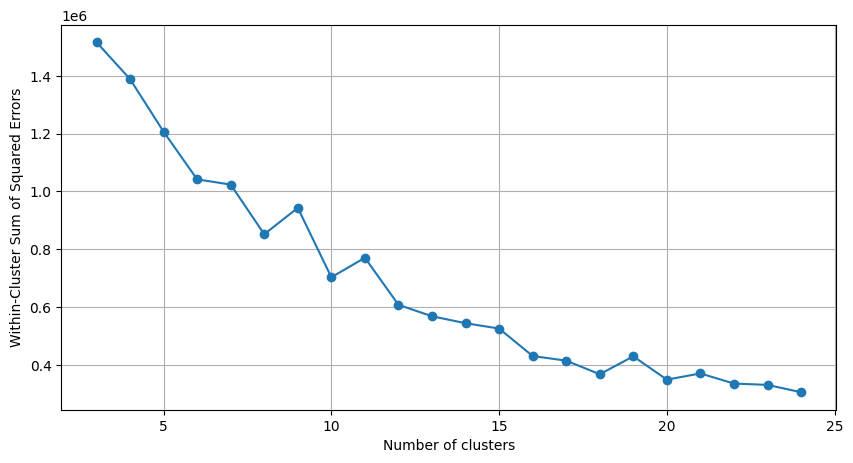

In [ ]:
# Find the optimal number of clusters
optimal_clusters(kmeans_df)

In [62]:
# Perform KMeans Clustering
kmeans = KMeans(featuresCol = 'features', k = 13, seed = 42)
model = kmeans.fit(kmeans_df)

# Make predictions
predictions = model.transform(kmeans_df)

# Evalue the clustering with the silhouette score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(predictions)
print('Silhouette Score: {:.4f}'.format(silhouette))

# Evaluate the clustering with the Davies-Bouldin Index
dbi_X = predictions.select(features).toPandas().values.tolist()
dbi_labels = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
dbi = davies_bouldin_score(dbi_X, dbi_labels)
print('Davies-Bouldin Index: {:.4f}'.format(dbi))

Silhouette Score: 0.7709
Davies-Bouldin Index: 1.3981


In [23]:
predictions.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|84268|
|         1|  275|
|         2|  100|
|         3|  304|
|         4|   20|
|         5|   26|
|         6|45987|
|         7|  127|
|         8| 5220|
|         9| 4856|
|        10|91034|
|        11| 4178|
|        12| 3282|
+----------+-----+



In [63]:
# Analyze the cluster centroids
centroids_summary = predictions.drop('features').groupBy('prediction').avg().orderBy('prediction').drop('avg(prediction)')

column_names = ['Prediction',
                'Avg_Number_Killed',
                'Avg_Number_Injured',
                'Avg_Guns_Involved',
                'Avg_Handgun_Freq',
                'Avg_Rifle_Freq',
                'Avg_Shotgun_Freq']
centroids_summary = centroids_summary.toDF(*column_names)

centroids_summary.show(13)
#centroids_summary.orderBy(desc('Avg_Guns_Involved')).show(13)

+----------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+
|Prediction|   Avg_Number_Killed|  Avg_Number_Injured| Avg_Guns_Involved|    Avg_Handgun_Freq|      Avg_Rifle_Freq|    Avg_Shotgun_Freq|
+----------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+
|         0|                 0.0|   1.118336735178241| 0.546102909764086|0.034675084254995964|4.153415294061803E-4|                 0.0|
|         1| 0.03636363636363636| 0.04363636363636364| 8.025454545454545|  1.7672727272727273|                4.56| 0.48727272727272725|
|         2|                 0.0|                0.02|              27.7|               23.91|                1.18|                0.27|
|         3| 0.03618421052631579|0.009868421052631578| 43.82236842105263| 0.10855263157894737| 0.08223684210526316| 0.03289473684210526|
|         4|                 0.0|        

There does not appear to be any obvious/meaningful patterns within the clusters, the highest average killings and injuries do not seem to be associated with any values in the amount of guns or type of gun.

## Spectral clustering analyzing number of participants killed, injured, guns involved, and type of gun ##**Runs out of RAM**

In [ ]:
features = ['n_killed',
            'n_injured',
            'n_guns_involved',
            'gun_type_handgun_freq',
            'gun_type_rifle_freq',
            'gun_type_shotgun_freq']
spectral_df = spark_df.select(features).toPandas()

# Scale the features
scaler = sklearn.preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(spectral_df)

spectral_df = pd.DataFrame(scaled_features, columns = features)
display(spectral_df.head())

,n_killed,n_injured,n_guns_involved,gun_type_handgun_freq,gun_type_rifle_freq,gun_type_shotgun_freq
0,-0.483519,0.693189,-0.220495,-0.150328,-0.071087,-0.100636
1,-0.483519,-0.676767,-0.220495,-0.150328,-0.071087,-0.100636
2,-0.483519,0.693189,-0.220495,-0.150328,-0.071087,-0.100636
3,-0.483519,0.693189,-0.220495,-0.150328,-0.071087,-0.100636
4,-0.483519,-0.676767,-0.220495,-0.150328,-0.071087,-0.100636


In [ ]:
# Perform Spectral Clustering
spectral = SpectralClustering(n_clusters = 13, random_state = 42).fit(spectral_df)

# Evaluate the clustering with the Silhouette score
silhouette = silhouette_score(spectral_df, spectral.labels_)
print('Silhouette Score: {:.4f}'.format(silhouette))

# Evaluate the clustering with the Davies-Bouldin Index
dbi = davies_bouldin_score(spectral_df, spectral.labels_)
print('Davies-Bouldin Index: {:.4f}'.format(dbi))

In [ ]:
# Display the cluster centroids
spectral_df['label'] = spectral.labels_
spectral_df = spectral_df[['label'] + features]
agg_df = spectral_df.groupby('label').mean()
agg_df.head(13)

## DBSCAN clustering analyzing number of participants killed, injured, guns involved, and type of gun ##**Runs out of RAM**

In [ ]:
# Select the desired features from the original dataframe
features = ['n_killed',
            'n_injured',
            'n_guns_involved']
            #'gun_type_handgun_freq',
            #'gun_type_rifle_freq',
            #'gun_type_shotgun_freq']

dbscan_df = spark_df.select(features).toPandas()

# Scale the features
scaler = sklearn.preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(dbscan_df)

dbscan_df = pd.DataFrame(scaled_features, columns = features)
display(dbscan_df.head())

,n_killed,n_injured,n_guns_involved
0,-0.492464,0.699479,-0.218628
1,-0.492464,-0.684353,-0.218628
2,-0.492464,0.699479,-0.218628
3,-0.492464,0.699479,-0.218628
4,-0.492464,-0.684353,-0.218628


In [ ]:
# Perform DBSCAN
db = DBSCAN(eps = 0.5, min_samples = 100).fit(dbscan_df)

# Print number of clusters and noisy points
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = list(db.labels_).count(-1)
print("Estimated number of clusters: %d" % n_clusters)
print('Estimated number of noisy points: %d' % n_noise)
print()

# Evaluate the clustering with the Silhouette score
silhouette = silhouette_score(dbscan_df, db.labels_)
print('Silhouette Score: {:.4f}'.format(silhouette))

# Evaluate the clustering with the Davies-Bouldin Index
dbi = davies_bouldin_score(dbscan_df, db.labels_)
print('Davies-Bouldin Index: {:.4f}'.format(dbi))